# IMPORT LIBRARY

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

import pymysql
import pymysql.cursors

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# LABELS, TIME PERIODS, STEP DISTANCE
### Set up label type, segment size, and time step size

In [5]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')

# Keras version indication
print('keras version ', keras.__version__)

# Set labels - LABELS
LABELS = ['branch_trip',
            'line_fault',
            'shunt_loss',
            'gen_loss',
            'load_loss',
            'vref']

# Timestamps per segment
TIME_PERIODS = 1000

# Steps when sliding to one segment to another (Sliding window)
STEP_DISTANCE = 100

# TIME_PERIODS = 1000, STEP_DISTANCE = 100, => overlapping timestamps = 900
# TIME_PERIODS = 1000, STEP_DISTANCE = 1000 => no overlapping timestamps

keras version  2.2.4


# SQL DATABASE
### Retrieve input data from MySQL database

In [6]:
# Connect database
connection = pymysql.connect(host='localhost',
                             user='root',  # MySQL user ID (Usually 'root')
                             password='Vansoff6',  # MySQL user password
                             db='sys',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()
sql = "SELECT * from sys.PMU"  # Retrieve every data(*) from'PMU' table
cursor.execute(sql)

result = cursor.fetchall()
connection.close()
print(result)

# Declare/store retrieved data as a dataframe format - df
df = pd.DataFrame(result)

# Reindex dataframe input column
df = df.reindex(columns=['timestamp','accident','voltage','frequency'])

# SHUFFLING
### Data Random Shuffle
Labeled data should be distributed randomly in order to evade bias.
Each training, test and validation data should contain unbiased labeled data to improve the performance.

In [7]:
# Convert input data to 3D array and shuffle
arr_3D = df.values.reshape(-1,1000,df.shape[1])
shuffle_idx = np.random.permutation(arr_3D.shape[0])
df = arr_3D[shuffle_idx]

In [8]:
m,n,r = df.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),df.reshape(m*n,-1)))
df = pd.DataFrame(out_arr, columns=['n','timestamp','accident','voltage','frequency'])
df = df.drop(columns=['n'])

In [13]:
# Print last 10 rows of input data
df.tail(10)

,timestamp,accident,voltage,frequency
11559990,990,load_loss,0.9,0.0
11559991,991,load_loss,0.9,0.0
11559992,992,load_loss,0.9,0.0
11559993,993,load_loss,0.9,0.0
11559994,994,load_loss,0.9,0.0
11559995,995,load_loss,0.9,0.0
11559996,996,load_loss,0.9,0.0
11559997,997,load_loss,0.9,0.0
11559998,998,load_loss,0.9,0.0
11559999,999,load_loss,0.9,0.0


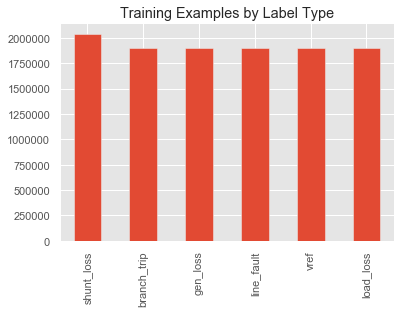

In [14]:
# Print data quantity according to label type
df['accident'].value_counts().plot(kind='bar',
                                   title='Training Examples by Label Type')
plt.show()

Text(0, 0.5, 'value')

<Figure size 432x288 with 0 Axes>

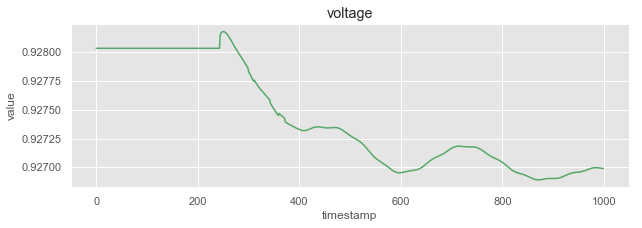

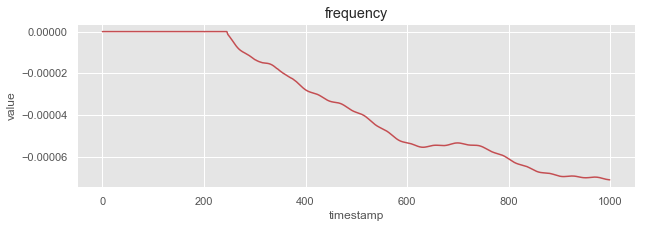

In [15]:
# Print voltage data graph of 1000 timestamps
plt.figure(1)
plt.subplots(figsize=(10, 3))
plt.plot(df['voltage'][:1000], 'g')
plt.title('voltage')
plt.xlabel('timestamp')
plt.ylabel('value')

# Print frequency data graph of 1000 timestamps
plt.figure(2)
plt.subplots(figsize=(10, 3))
plt.plot(df['frequency'][:1000], 'r')
plt.title('frequency')
plt.xlabel('timestamp')
plt.ylabel('value')

# LABEL ENCODING

ex) if branch_trip, label = 0, if shunt_loss, label = 1 etc. The value the machine can recognize.

In [16]:
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['accident'].values.ravel())

# TRAINING/TEST DATA DIVISION

As for this model, train_size = 80%, test_size = 20%

In [17]:
# train_size = 80%, test_size = total - train_size = 20%
train_size = len(df) // 10 * 8
test_size = len(df) - train_size

# Trainig dataset = df_train
# Test dataset = df_test
df_train = df[0:train_size]
df_test = df[train_size:len(df)]

print(df_train.shape)
print(df_test.shape)

(9248000, 5)
(2312000, 5)


In [18]:
# Max. frequency data
# As for Max.voltage data -> type 'df['voltage'].max()'
df['frequency'].max()

0.0105575

# NORMALIZATION(STANDARDIZATION)
### 정규화(표준화)

Rescaling process such as normalization prevent from generating noise data.

'voltage' max value was approx. 1.2
'frequency' max value was approx. 0.009
=> Divide by each max value

In [19]:
# Normalize all the training dataset to value from 0 to 1
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df['voltage'] = df['voltage'] / 1.21
df['frequency'] = df['frequency'] / 0.01

# Round numbers - % decimal point
df = df.round({'voltage': 4, 'frequency': 4})
df.tail(5)

,timestamp,accident,voltage,frequency,ActivityEncoded
11559995,995,load_loss,0.8,0.0,3
11559996,996,load_loss,0.8,0.0,3
11559997,997,load_loss,0.8,0.0,3
11559998,998,load_loss,0.8,0.0,3
11559999,999,load_loss,0.8,0.0,3


In [20]:
# Print max frequency data after normalization
df['frequency'].max()

1.05575

Text(0, 0.5, 'value')

<Figure size 432x288 with 0 Axes>

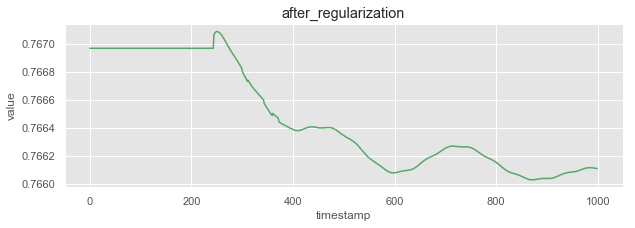

In [21]:
# Print time-series data of 1000 timestamps after normalization
plt.figure(1)
plt.subplots(figsize=(10, 3))
plt.plot(df['voltage'][:1000], 'g')
plt.title('after_regularization')
plt.xlabel('timestamp')
plt.ylabel('value')

# CREATE SEGMENTS AND LABELS

Since we set TIME_PERIODS to 1000, STEP_DISTANCE to 100, each segment has the voltage and frequency data of 1000 timestamps.

In [22]:
# Create time segment
def create_segments_and_labels(df, time_steps, step, label_name):

    # number of features
    N_FEATURES = 2

    # Declare segments and labels
    segments = []
    labels = []
    
    # Time segment length TIME_PERIODS = 1000
    # Time segment gap STEP_DISTANCE = 100 (Overlapping distance = 1000 - 100 = 900)
    # 1 Segment equals voltage and frequency data of 1000 timestamps
    # Shape of one segment equals (2,1000)
    for i in range(0, len(df) - time_steps, step):
        xs = df['voltage'].values[i: i + time_steps]
        ys = df['frequency'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

# create_segments_and_labels(input dataset, time segment length(1000), segment step distance(100), labels(6))
# Original input column ['timestamp','accident','voltage','frequency']
# y_train gets ['accident']
# x_train gets ['voltage','frequency'] - feature values
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [23]:
# Print x_train and y_train shapes
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (92470, 1000, 2)
92470 training samples
y_train shape:  (92470,)


In [24]:
# num_time_periods = 1000, num_sensors = 2
# Print label-encoded 6 accident types
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['branch_trip', 'gen_loss', 'line_fault', 'load_loss', 'shunt_loss', 'vref']


In [25]:
#num_sensors(number of features) = 2, num_time_periods = TIME_PERIODS = 1000
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)
print(num_sensors)

x_train shape: (92470, 2000)
input_shape: 2000
2


In [26]:
# Convert to 'float32' type
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [27]:
# Convert class vector to binary class matrix (Sort of one-hot encoding)
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (92470, 6)


# Keras Neural Network Model Tuning

1. Total 3 Dense Layer
2. Apply softmax activation function
3. Dropout rate = 0.2
4. Model training purpose = 'cetegorical_crossentropy'
5. Enable EarlyStopping -> if (previous epoch > current epoch) break
6. Hyperparameter tuning: Batch size = 200 to 300, Epoch(training) = 15 to 25
7. Validation split 0.2 -> Data validation for measuring model accuracy

In [73]:
# Hyperparameter tuning
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, 2), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu')) # shape (*, 100) / dense layer 1
model_m.add(Dense(100, activation='relu')) # shape (*, 100) / dense layer 2
model_m.add(Flatten())
model_m.add(Dropout(0.2)) # Dropout 0.2
model_m.add(Dense(num_classes, activation='softmax')) # softmax activation function / dense layer 3
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_28 (Reshape)         (None, 1000, 2)           0         
_________________________________________________________________
dense_16 (Dense)             (None, 1000, 100)         300       
_________________________________________________________________
dense_17 (Dense)             (None, 1000, 100)         10100     
_________________________________________________________________
flatten_6 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100000)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 600006    
Total params: 610,406
Trainable params: 610,406
Non-trainable params: 0
_________________________________________________________________
None

In [22]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
] # Early Stopping method

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyperparameter tuning
BATCH_SIZE = 300 # Set batch size
EPOCHS = 20 # Set epoch size

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,  # Validation split 20% from total data
                      verbose=1) #

Instructions for updating:
Use tf.cast instead.
Train on 73976 samples, validate on 18494 samples
Epoch 1/20
73976/73976 [==============================] - 557s 8ms/step - loss: 1.0363 - acc: 0.5869 - val_loss: 0.7529 - val_acc: 0.7029
Epoch 2/20
73976/73976 [==============================] - 542s 7ms/step - loss: 0.6359 - acc: 0.7606 - val_loss: 0.5433 - val_acc: 0.7763
Epoch 3/20
73976/73976 [==============================] - 534s 7ms/step - loss: 0.5103 - acc: 0.8059 - val_loss: 0.4570 - val_acc: 0.8196
Epoch 4/20
73976/73976 [==============================] - 532s 7ms/step - loss: 0.4509 - acc: 0.8265 - val_loss: 0.4080 - val_acc: 0.8543
Epoch 5/20
73976/73976 [==============================] - 533s 7ms/step - loss: 0.4022 - acc: 0.8459 - val_loss: 0.3659 - val_acc: 0.8673
Epoch 6/20
73976/73976 [==============================] - 533s 7ms/step - loss: 0.3704 - acc: 0.8605 - val_loss: 0.3521 - val_acc: 0.8700
Epoch 7/20
73976/73976 [==============================] - 532s 7ms/step - 

# ACCURACY MEASUREMENT
### 정확도 측정

Lesser the loss of training and validation data, higher the performance of model has.

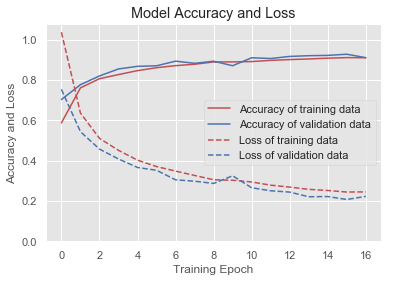

              precision    recall  f1-score   support

         0.0       0.77      0.91      0.83     16403
         1.0       0.99      0.99      0.99     15917
         2.0       0.93      0.91      0.92     15393
         3.0       0.98      0.86      0.91     15219
         4.0       0.95      0.98      0.97     15458
         5.0       0.91      0.82      0.86     14080

   micro avg       0.91      0.91      0.91     92470
   macro avg       0.92      0.91      0.91     92470
weighted avg       0.92      0.91      0.91     92470



In [23]:
# Visualize accuracy of training and validation data as epoch size increases
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print classfication result
# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [24]:
# Create time segment again for test dataset
x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Reshape test dataset
# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

# Convert dataset to float32 type
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

# Measure model performance by comparing trained model with test dataset
y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

23110/23110 [==============================] - 47s 2ms/step

Accuracy on test data: 0.91

Loss on test data: 0.22


In [25]:
# Print test dataset
x_test

array([[ 8.4710741e-01,  8.4710741e-01,  8.4710741e-01, ...,
         1.9513100e-02,  1.9528801e-02,  1.9544899e-02],
       [ 8.4710741e-01,  8.4710741e-01,  8.4710741e-01, ...,
         1.2067500e-07,  9.0506099e-08,  1.8645900e-07],
       [ 8.4710741e-01,  8.4710741e-01,  8.4710741e-01, ...,
        -3.9960099e-08,  8.8609603e-08,  6.6457197e-08],
       ...,
       [ 7.8967935e-01,  7.8967935e-01,  7.8967935e-01, ...,
        -9.8297501e-04, -9.8387699e-04, -9.8467199e-04],
       [ 7.8967935e-01,  7.8967935e-01,  7.8967935e-01, ...,
        -1.2229700e-03, -1.2261200e-03, -1.2295600e-03],
       [ 7.8967935e-01,  7.8967935e-01,  7.8967935e-01, ...,
        -1.4001700e-03, -1.4008899e-03, -1.4016600e-03]], dtype=float32)

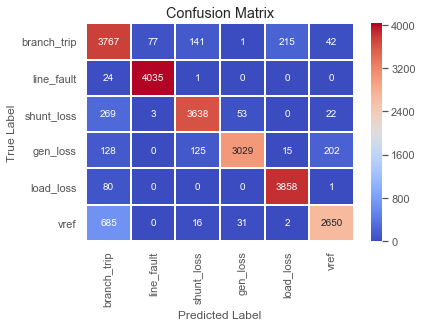

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      4243
           1       0.98      0.99      0.99      4060
           2       0.93      0.91      0.92      3985
           3       0.97      0.87      0.92      3499
           4       0.94      0.98      0.96      3939
           5       0.91      0.78      0.84      3384

   micro avg       0.91      0.91      0.91     23110
   macro avg       0.92      0.90      0.91     23110
weighted avg       0.91      0.91      0.91     23110



In [26]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
# Print confusion matrix (predicted vs. actual)
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

# SYSTEM DATA(SIMULATION DATA) CLASSIFICATION PREDICTION
### 시스템 데이터 분류 예측



In [27]:
# Read system data from csv file
# s14는 shunt loss 파일, g14는 generation_loss 파일
s14 = pd.read_csv('/Users/jill/Pictures/data/new_shunt_loss_2cy_13.csv', 'r', delimiter=',', header = None)
g14 = pd.read_csv('/Users/jill/Pictures/data/new_gen_loss_2cy_14.csv', 'r', delimiter=',', header = None)

# Preprocessing input data
def shunt_loss(df):
    dff = df.loc[:,1:]
    dff = dff.loc[:,:1000]
    dff = dff.T
    dtt = df.loc[:,1:1000]
    dtt = dtt.loc[0:0,:]
    dtt = dtt.T
    #voltage preprocessing
    voltage = dff.loc[:,1].append(dff.loc[:,2])
    for i in range(66):
        index = i+3
        voltage = voltage.append(dff.loc[:,index])
    #frequency preprocessing
    frequency = dff.loc[:,69].append(dff.loc[:,70])
    for i in range(66):
        indexx = i+71
        frequency = frequency.append(dff.loc[:,indexx])
    #timestamp preprocessing
    import itertools
    timestamp = dtt.append(dtt)
    for i in itertools.repeat(None, 66):
        timestamp = timestamp.append(dtt)
    sumup = pd.concat([timestamp, voltage, frequency], axis = 1)
    sumup.columns = ['timestamp', 'voltage', 'frequency']
    sumup.insert(1, 'accident', 'shunt_loss')
#     sumup.insert(0, 'label', 1)
#     sumup.to_csv('/Users/jill/Desktop/testt.csv')
    return sumup

def gen_loss(df):
    dff = df.loc[1:,1:]
    dff = dff.loc[:,:1000]
    dff = dff.T
    dtt = df.loc[:,1:1000]
    dtt = dtt.loc[0:0,:]
    dtt = dtt.T
    #voltage preprocessing
    voltage = dff.loc[:,1].append(dff.loc[:,2])
    for i in range(66):
        index = i+3
        voltage = voltage.append(dff.loc[:,index])
    #frequency preprocessing
    frequency = dff.loc[:,69].append(dff.loc[:,70])
    for i in range(66):
        indexx = i+71
        frequency = frequency.append(dff.loc[:,indexx])
    #timestamp preprocessing
    import itertools
    timestamp = dtt.append(dtt)
    for i in itertools.repeat(None, 66):
        timestamp = timestamp.append(dtt)
    sumup = pd.concat([timestamp, voltage, frequency], axis = 1)
    sumup.columns = ['timestamp', 'voltage', 'frequency']
    sumup.insert(1, 'accident', 'gen_loss')
#     sumup.insert(0, 'label', 1)
#     sumup.to_csv('/Users/jill/Desktop/testt.csv')
    return sumup

In [28]:
tt = shunt_loss(s14)
tt.head(5)

,timestamp,accident,voltage,frequency
1,0.0,shunt_loss,1.0,0.0
2,1.0,shunt_loss,1.0,0.0
3,2.0,shunt_loss,1.0,0.0
4,3.0,shunt_loss,1.0,0.0
5,4.0,shunt_loss,1.0,0.0


In [29]:
# Normalization using the same process done from the previous one
pd.options.mode.chained_assignment = None  # default='warn'
# df['voltage'] = df['voltage'] / df['voltage'].max()
# df['frequency'] = df['frequency'] / df['frequency'].max()
tt['voltage'] = tt['voltage'] / 1.21 
tt['frequency'] = tt['frequency'] / 0.01
# Round numbers
tt = tt.round({'voltage': 4, 'frequency': 4})
tt.tail(5)

,timestamp,accident,voltage,frequency
996,995.0,shunt_loss,0.8,-0.0
997,996.0,shunt_loss,0.8,-0.0
998,997.0,shunt_loss,0.8,-0.0
999,998.0,shunt_loss,0.8,-0.0
1000,999.0,shunt_loss,0.8,-0.0


In [30]:
# Create timesegment using the same process done from the previous one
N_FEATURES = 2

segments = []
xs = tt['voltage'].values[:TIME_PERIODS]
ys = tt['frequency'].values[:TIME_PERIODS]
# Retrieve the most often used label in this segment
segments.append([xs, ys])

# Bring the segments into a better shape
xx_test = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_PERIODS, N_FEATURES)

xx_test = xx_test.reshape(xx_test.shape[0], input_shape)

xx_test = xx_test.astype('float32')

# Reshape
test_record = xx_test[0].reshape(1,input_shape)
predict = np.argmax(model_m.predict(test_record), axis = 1)
# print()

# Check classification result
print(predict[0])  # Print predicted encoded label value
print(le.inverse_transform(predict)[0])  # Print inverse-transformed label value
print(xx_test.shape)  # Print shape of predicted segment

4
shunt_loss
(1, 2000)


# PMU DATA CLASSIFICATION PREDICTION
### 실 계통 데이터 분류 예측

Classification based on the actual PMU data

In [42]:
# Set dataset columns
column_name = ['timestamp',
                 'voltage',
                  'frequency']

# Read PMU dataset 
# MIGEUM_0625.csv = MIGEUM electrical grid accident data on June 25th 2019
# MIGEUM_0702.csv = SINSIHEUNG electrical grid accident data on July 2nd 2019
# (Refer to the PMU-Pattern-Recognition-CNN-2.ipynb)
tt = pd.read_csv('/Users/jill/Desktop/MIGEUM_0625.csv', 'r', delimiter=',', header = None,
                                                            names = column_name)

migeum = tt  
tt.head(10)  # Print first 10 rows

,timestamp,voltage,frequency
0,2019-06-24 17:05:32.0000000Z,1.0,-0.0
1,2019-06-24 17:05:32.0166667Z,1.0,-0.0
2,2019-06-24 17:05:32.0333333Z,1.0,-0.0
3,2019-06-24 17:05:32.0500000Z,1.0,-0.0
4,2019-06-24 17:05:32.0666667Z,1.0,-0.0
5,2019-06-24 17:05:32.0833333Z,1.0,-0.0
6,2019-06-24 17:05:32.1000000Z,1.0,-0.0
7,2019-06-24 17:05:32.1166667Z,1.0,-0.0
8,2019-06-24 17:05:32.1333333Z,1.0,-0.0
9,2019-06-24 17:05:32.1500000Z,1.0,-0.0


In [32]:
# def create_predictions(tt, time_steps, step, label_name):

#     # x, y, z acceleration as features
#     N_FEATURES = 2
#     # Number of steps to advance in each iteration (for me, it should always
#     # be equal to the time_steps in order to have no overlap between segments)
#     # step = time_steps
#     segments = []
#     labels = []
#     for i in range(0, len(tt) - time_steps, step):
#         xs = tt['voltage'].values[i: i + time_steps]
#         ys = tt['frequency'].values[i: i + time_steps]
#         # Retrieve the most often used label in this segment
#         label = stats.mode(tt[label_name][i: i + time_steps])[0][0]
#         segments.append([xs, ys])
#         labels.append(label)

#     # Bring the segments into a better shape
#     reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
#     labels = np.asarray(labels)

#     return reshaped_segments, labels

In [43]:
list(le.classes_)  # Print labels

[u'branch_trip',
 u'gen_loss',
 u'line_fault',
 u'load_loss',
 u'shunt_loss',
 u'vref']

In [44]:
# Normalization
pd.options.mode.chained_assignment = None  # default='warn'
# df['voltage'] = df['voltage'] / df['voltage'].max()
# df['frequency'] = df['frequency'] / df['frequency'].max()
tt['voltage'] = tt['voltage'] / 1.21 
tt['frequency'] = tt['frequency'] / 0.01
# Round numbers
tt = tt.round({'voltage': 4, 'frequency': 4})
tt.tail(5)

,timestamp,voltage,frequency
3995,2019-06-24 17:05:48.5833333Z,0.8,0.0
3996,2019-06-24 17:05:48.6000000Z,0.8,0.0
3997,2019-06-24 17:05:48.6166667Z,0.8,0.0
3998,2019-06-24 17:05:48.6333333Z,0.8,0.0
3999,2019-06-24 17:05:48.6500000Z,0.8,0.0


In [45]:
# Create time segment
N_FEATURES = 2

segments = []
xs = tt['voltage'].values[:TIME_PERIODS]
ys = tt['frequency'].values[:TIME_PERIODS]
# Retrieve the most often used label in this segment
segments.append([xs, ys])

# Bring the segments into a better shape
xx_test = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_PERIODS, N_FEATURES)

xx_test = xx_test.reshape(xx_test.shape[0], input_shape)

xx_test = xx_test.astype('float32')

xx_test

array([[0.8502, 0.8502, 0.8502, ..., 0.0072, 0.007 , 0.0068]],
      dtype=float32)

Text(0,0.5,'frequency')

<Figure size 432x288 with 0 Axes>

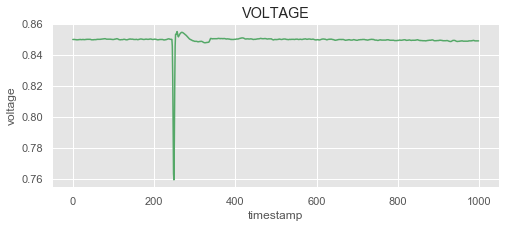

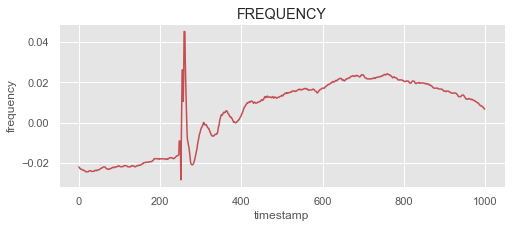

In [46]:
# PMU data graph visualization
plt.figure(1)
plt.subplots(figsize=(8, 3))
plt.plot(tt['voltage'][:1000], 'g')
plt.title('VOLTAGE')
plt.xlabel('timestamp')
plt.ylabel('voltage')

plt.figure(2)
plt.subplots(figsize=(8, 3))
plt.plot(tt['frequency'][:1000], 'r')
plt.title('FREQUENCY')
plt.xlabel('timestamp')
plt.ylabel('frequency')

In [47]:
# Check classification result
test_record = xx_test[0].reshape(1,input_shape)
predict = np.argmax(model_m.predict(test_record), axis = 1)
# print()
print(predict[0])  # Print predicted label value
print(le.inverse_transform(predict)[0])  # Print predicted inverse-transformed label value
print(xx_test.shape)  # Print predicted segment shape

# coreml_prediction = coreml_model.predict({'acceleration': test_record.reshape(input_shape)})
# print('\nPrediction from Coreml: ', coreml_prediction["classLabel"])
    
# print(test_record)
# keras_prediction = np.argmax(model_m.predict(test_record), axis=1)
# print(le.inverse_transform(keras_prediction)[0])
## coreml_prediction = coreml_model.predict({'acceleration': test_record.reshape(input_shape)})
#     print(coreml_prediction["classLabel"])
## print('\nPrediction from Coreml: ', coreml_prediction["classLabel"])

2
line_fault
(1, 2000)


# SAVE MODEL
### 모델 저장

In [48]:
model_json = model_m.to_json()
with open("/Users/jill/Desktop/model_2.json","w") as json_file :  # Save CNN model (json)
    json_file.write(model_json)

In [49]:
model_m.save_weights("/Users/jill/Desktop/model_2.h5")  # Save weight file (h5)